Script that assembles various data sources for electricity demand in Victoria. Extra features include:<br>
- Minimum and maximum temperatures on that day at Olympic Part (near Melbourne CBD).
- Whenever the day was either state or federal holiday (Y, N).
- Whenever students were at schools or not (Y, N)

In [1]:
import pandas as pd
import numpy as np

Minimum and maximum temperature (values only at Olympic Park weather station). Can be improved by weighting different stations by population numbers.

In [2]:
df_minT = pd.read_csv("Weather_Melbourne/minT_086338.csv")
df_maxT = pd.read_csv("Weather_Melbourne/maxT_086338.csv")
df_minT = df_minT.rename(columns = {"Bureau of Meteorology station number" : "Site"})
df_maxT = df_maxT.rename(columns = {"Bureau of Meteorology station number" : "Site"})
df_T = df_minT[['Site', 'Year', 'Month', 'Day', 'Minimum temperature (Degree C)']]
df_T = df_T.merge(df_maxT['Maximum temperature (Degree C)'], left_index=True, right_index=True)
df_T = df_T.rename(columns = {'Maximum temperature (Degree C)' : 'Maximum Temperature', 'Minimum temperature (Degree C)' : 'Minimum Temperature'})
df_T = df_T.drop(['Site'], axis=1)
df_T

,Year,Month,Day,Minimum Temperature,Maximum Temperature
0,2013,1,1,NaN,NaN
1,2013,1,2,NaN,NaN
2,2013,1,3,NaN,NaN
3,2013,1,4,NaN,NaN
4,2013,1,5,NaN,NaN
...,...,...,...,...,...
2831,2020,10,2,12.8,26.0
2832,2020,10,3,17.4,29.4
2833,2020,10,4,13.5,29.5
2834,2020,10,5,9.1,12.7


In [3]:
from os import listdir

df_demand = []

for filename in listdir("./Price_Demand_Data"):
    df_demand.append(pd.read_csv(f"Price_Demand_Data/{filename}"))

df_demand = pd.concat(df_demand, axis=0, ignore_index=True)
df_demand['SETTLEMENTDATE'] = pd.to_datetime(df_demand['SETTLEMENTDATE'], format='%Y-%m-%d %H:%M:%S')

df_demand = df_demand.sort_values(by='SETTLEMENTDATE').reset_index()[['SETTLEMENTDATE', 'TOTALDEMAND', 'RRP']]
df_demand['DATE'] = df_demand['SETTLEMENTDATE'].apply(lambda x: x.date())
df_reg = df_demand[df_demand['RRP'] > 0]
df_notreg = df_demand[df_demand['RRP'] <= 0]
df_notreg

,SETTLEMENTDATE,TOTALDEMAND,RRP,DATE
37,2015-01-01 19:00:00,4631.58,-7.24,2015-01-01
70,2015-01-02 11:30:00,5406.19,-10.11,2015-01-02
72,2015-01-02 12:30:00,5703.12,-49.60,2015-01-02
73,2015-01-02 13:00:00,5938.68,-80.41,2015-01-02
317,2015-01-07 15:00:00,8032.21,-1.10,2015-01-07
...,...,...,...,...
100989,2020-10-04 23:00:00,3737.32,-0.48,2020-10-04
100995,2020-10-05 02:00:00,3585.28,-6.31,2020-10-05
100996,2020-10-05 02:30:00,3510.14,-12.70,2020-10-05
100997,2020-10-05 03:00:00,3474.64,-3.94,2020-10-05


Interestingly, there are a few record with negative prices. The most likely explanation for this is a discrepancy between generators forecasts and real demand. Lets add some features:
- Total damand per day at negative prices
- Fraction of the day at negative prices
- negative and components of the average daily price

In [4]:
df_reg['pRRP'] = df_reg['RRP'] * df_reg['TOTALDEMAND']
df_reg = df_reg.drop(['RRP'], axis=1)

df_reg = df_reg.groupby('DATE').agg(sum)

df_reg = df_reg.reset_index()
df_reg

df_notreg['nRRP'] = df_notreg['RRP'] * df_notreg['TOTALDEMAND']
df_notreg = df_notreg.drop(['RRP'], axis=1)
df_notreg['FracNegative'] = 1
df_notreg = df_notreg.groupby('DATE').agg(sum)
df_notreg['FracNegative'] = df_notreg['FracNegative'].astype(np.float32)/48

df_notreg = df_notreg.reset_index()
df_notreg

<ipython-input-4-54aa0b17ca04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['pRRP'] = df_reg['RRP'] * df_reg['TOTALDEMAND']
<ipython-input-4-54aa0b17ca04>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notreg['nRRP'] = df_notreg['RRP'] * df_notreg['TOTALDEMAND']


,DATE,TOTALDEMAND,nRRP,FracNegative
0,2015-01-01,4631.58,-3.353264e+04,0.020833
1,2015-01-02,17047.99,-8.150606e+05,0.062500
2,2015-01-07,8032.21,-8.835431e+03,0.020833
3,2015-01-18,4509.57,-6.685888e+05,0.020833
4,2015-02-13,5984.16,-1.906912e+06,0.020833
...,...,...,...,...
186,2020-10-01,22584.36,-5.516665e+05,0.125000
187,2020-10-02,115195.19,-3.475879e+06,0.625000
188,2020-10-03,96287.03,-3.229277e+06,0.583333
189,2020-10-04,11001.14,-1.793914e+03,0.062500


In [5]:
# Weighted daily average for RRP. Weighted by demand.
df_demand['wRRP'] = df_demand['RRP'] * df_demand['TOTALDEMAND']
df_demand = df_demand.drop(['RRP'], axis=1)

df_demand = df_demand.groupby('DATE').agg(sum)
df_demand['RRP'] = df_demand['wRRP'] / df_demand['TOTALDEMAND']

df_demand = df_demand.drop(['wRRP'], axis=1)
df_demand = df_demand.reset_index()
df_demand

,DATE,TOTALDEMAND,RRP
0,2015-01-01,199270.06,25.633696
1,2015-01-02,259212.02,33.138988
2,2015-01-03,284601.08,34.564855
3,2015-01-04,208661.43,25.005560
4,2015-01-05,236264.40,26.724176
...,...,...,...
2103,2020-10-04,188163.13,25.008614
2104,2020-10-05,227220.06,36.764701
2105,2020-10-06,245215.12,75.771059
2106,2020-10-07,241919.81,129.516975


In [6]:
df_demand = df_demand.rename(columns={'DATE' : 'Date', 'TOTALDEMAND' : 'Demand'})
df_reg = df_reg.rename(columns={'DATE' : 'Date', 'TOTALDEMAND' : 'pDemand'})
df_notreg = df_notreg.rename(columns={'DATE' : 'Date', 'TOTALDEMAND' : 'nDemand'})

df_demand['Day'] = df_demand['Date'].apply(lambda x: x.day)
df_demand['Month'] = df_demand['Date'].apply(lambda x: x.month)
df_demand['Year'] = df_demand['Date'].apply(lambda x: x.year)
df_demand

,Date,Demand,RRP,Day,Month,Year
0,2015-01-01,199270.06,25.633696,1,1,2015
1,2015-01-02,259212.02,33.138988,2,1,2015
2,2015-01-03,284601.08,34.564855,3,1,2015
3,2015-01-04,208661.43,25.005560,4,1,2015
4,2015-01-05,236264.40,26.724176,5,1,2015
...,...,...,...,...,...,...
2103,2020-10-04,188163.13,25.008614,4,10,2020
2104,2020-10-05,227220.06,36.764701,5,10,2020
2105,2020-10-06,245215.12,75.771059,6,10,2020
2106,2020-10-07,241919.81,129.516975,7,10,2020


Merge with positive and negative price data

In [7]:
df_notreg

,Date,nDemand,nRRP,FracNegative
0,2015-01-01,4631.58,-3.353264e+04,0.020833
1,2015-01-02,17047.99,-8.150606e+05,0.062500
2,2015-01-07,8032.21,-8.835431e+03,0.020833
3,2015-01-18,4509.57,-6.685888e+05,0.020833
4,2015-02-13,5984.16,-1.906912e+06,0.020833
...,...,...,...,...
186,2020-10-01,22584.36,-5.516665e+05,0.125000
187,2020-10-02,115195.19,-3.475879e+06,0.625000
188,2020-10-03,96287.03,-3.229277e+06,0.583333
189,2020-10-04,11001.14,-1.793914e+03,0.062500


In [8]:
df_demand = df_demand.merge(df_reg, how='left', on = 'Date')
df_demand = df_demand.merge(df_notreg, how='left', on = 'Date')
df_demand['nRRP'] = df_demand['nRRP']/df_demand['Demand']
df_demand['pRRP'] = df_demand['pRRP']/df_demand['Demand']
df_demand

,Date,Demand,RRP,Day,Month,Year,pDemand,pRRP,nDemand,nRRP,FracNegative
0,2015-01-01,199270.06,25.633696,1,1,2015,194638.48,25.801974,4631.58,-0.168277,0.020833
1,2015-01-02,259212.02,33.138988,2,1,2015,242164.03,36.283366,17047.99,-3.144378,0.062500
2,2015-01-03,284601.08,34.564855,3,1,2015,284601.08,34.564855,NaN,NaN,NaN
3,2015-01-04,208661.43,25.005560,4,1,2015,208661.43,25.005560,NaN,NaN,NaN
4,2015-01-05,236264.40,26.724176,5,1,2015,236264.40,26.724176,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2103,2020-10-04,188163.13,25.008614,4,10,2020,177161.99,25.018147,11001.14,-0.009534,0.062500
2104,2020-10-05,227220.06,36.764701,5,10,2020,213174.75,37.167203,14045.31,-0.402503,0.083333
2105,2020-10-06,245215.12,75.771059,6,10,2020,245215.12,75.771059,NaN,NaN,NaN
2106,2020-10-07,241919.81,129.516975,7,10,2020,241919.81,129.516975,NaN,NaN,NaN


In [9]:
df_demand = df_demand.fillna(0)

Merge with Temperature data. Temperature has a daily resolution, so tiling interday times.

In [10]:
df_demand = df_demand.merge(df_T, how='left', on=['Year', 'Month', 'Day'])#.dropna()
df_demand

,Date,Demand,RRP,Day,Month,Year,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature
0,2015-01-01,199270.06,25.633696,1,1,2015,194638.48,25.801974,4631.58,-0.168277,0.020833,13.3,26.9
1,2015-01-02,259212.02,33.138988,2,1,2015,242164.03,36.283366,17047.99,-3.144378,0.062500,15.4,38.8
2,2015-01-03,284601.08,34.564855,3,1,2015,284601.08,34.564855,0.00,0.000000,0.000000,20.0,38.2
3,2015-01-04,208661.43,25.005560,4,1,2015,208661.43,25.005560,0.00,0.000000,0.000000,16.3,21.4
4,2015-01-05,236264.40,26.724176,5,1,2015,236264.40,26.724176,0.00,0.000000,0.000000,15.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,2020-10-04,188163.13,25.008614,4,10,2020,177161.99,25.018147,11001.14,-0.009534,0.062500,13.5,29.5
2104,2020-10-05,227220.06,36.764701,5,10,2020,213174.75,37.167203,14045.31,-0.402503,0.083333,9.1,12.7
2105,2020-10-06,245215.12,75.771059,6,10,2020,245215.12,75.771059,0.00,0.000000,0.000000,8.9,12.6
2106,2020-10-07,241919.81,129.516975,7,10,2020,241919.81,129.516975,0.00,0.000000,0.000000,NaN,NaN


In [11]:
df_demand = df_demand[:-2]
df_demand

,Date,Demand,RRP,Day,Month,Year,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature
0,2015-01-01,199270.06,25.633696,1,1,2015,194638.48,25.801974,4631.58,-0.168277,0.020833,13.3,26.9
1,2015-01-02,259212.02,33.138988,2,1,2015,242164.03,36.283366,17047.99,-3.144378,0.062500,15.4,38.8
2,2015-01-03,284601.08,34.564855,3,1,2015,284601.08,34.564855,0.00,0.000000,0.000000,20.0,38.2
3,2015-01-04,208661.43,25.005560,4,1,2015,208661.43,25.005560,0.00,0.000000,0.000000,16.3,21.4
4,2015-01-05,236264.40,26.724176,5,1,2015,236264.40,26.724176,0.00,0.000000,0.000000,15.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,199171.67,-6.076028,2,10,2020,83976.48,11.375646,115195.19,-17.451675,0.625000,12.8,26.0
2102,2020-10-03,184554.05,-1.983471,3,10,2020,88267.02,15.514259,96287.03,-17.497730,0.583333,17.4,29.4
2103,2020-10-04,188163.13,25.008614,4,10,2020,177161.99,25.018147,11001.14,-0.009534,0.062500,13.5,29.5
2104,2020-10-05,227220.06,36.764701,5,10,2020,213174.75,37.167203,14045.31,-0.402503,0.083333,9.1,12.7


Add School terms and Holidays

In [12]:
df_school = pd.read_csv("Vic_School_Terms.csv")
df_holidays = pd.read_csv('Vic_Holidays.csv')

In [13]:
df_school['Start date'] = pd.to_datetime(df_school['Start date'], format="%d %B %Y")
df_school['Finish date'] = pd.to_datetime(df_school['Finish date'], format="%d %B %Y")
df_school.head()

,terms,Start date,Finish date
0,Term 1,2020-01-29,2020-03-24
1,Term 2,2020-05-26,2020-06-26
2,Term 3,2020-07-13,2020-08-04
3,Term 1,2019-01-30,2019-04-05
4,Term 2,2019-04-23,2019-06-28


In [14]:
# Make a function that checks the date to be a school day (Y) or not (N, remote = N)

vals_school = df_school[['Start date', 'Finish date']].values

def at_school(date):
    """
    Check if on the date is schools were open (Y) or closed/remote (N).
    """    
    for terms in vals_school:
        if date < terms[1] and date > terms[0]: return 'Y'
    return 'N' 

school_test = pd.to_datetime(['20-01-2020', '01-03-2020', '14-08-2015', '01-07-2015'], format="%d-%m-%Y")
for date in school_test:
    print(f"{date} - {at_school(date)}")

2020-01-20 00:00:00 - N
2020-03-01 00:00:00 - Y
2015-08-14 00:00:00 - Y
2015-07-01 00:00:00 - N


In [15]:
df_demand['SchoolDay'] = pd.to_datetime(df_demand['Date'], format="%Y-%m-%d").apply(at_school)

<ipython-input-15-4e94eaaf97b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand['SchoolDay'] = pd.to_datetime(df_demand['Date'], format="%Y-%m-%d").apply(at_school)


In [16]:
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'], format="%d %B %Y")

vals_holidays = np.array([v.astype('datetime64[D]') for v in df_holidays['Date'].values])

def is_holiday(date):
    """
    Check if on the date is a public holiday in Victoria.
    Time is of no importance, only date!
    """    
    if date.date() in vals_holidays: return 'Y'
    return 'N'

holiday_test = pd.to_datetime(['20-01-2020', '03-11-2020', '14-08-2015', '03-04-2015'], format="%d-%m-%Y")
for date in holiday_test:
    print(f"{date} - {is_holiday(date)}")

2020-01-20 00:00:00 - N
2020-11-03 00:00:00 - Y
2015-08-14 00:00:00 - N
2015-04-03 00:00:00 - Y


In [17]:
df_demand['Holiday'] = pd.to_datetime(df_demand['Date'], format="%Y-%m-%d").apply(is_holiday)

<ipython-input-17-d5df0517cc57>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand['Holiday'] = pd.to_datetime(df_demand['Date'], format="%Y-%m-%d").apply(is_holiday)


In [18]:
df_demand = df_demand.drop(['Day', 'Month', 'Year'], axis=1)
df_demand

,Date,Demand,RRP,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature,SchoolDay,Holiday
0,2015-01-01,199270.06,25.633696,194638.48,25.801974,4631.58,-0.168277,0.020833,13.3,26.9,N,Y
1,2015-01-02,259212.02,33.138988,242164.03,36.283366,17047.99,-3.144378,0.062500,15.4,38.8,N,N
2,2015-01-03,284601.08,34.564855,284601.08,34.564855,0.00,0.000000,0.000000,20.0,38.2,N,N
3,2015-01-04,208661.43,25.005560,208661.43,25.005560,0.00,0.000000,0.000000,16.3,21.4,N,N
4,2015-01-05,236264.40,26.724176,236264.40,26.724176,0.00,0.000000,0.000000,15.0,22.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,199171.67,-6.076028,83976.48,11.375646,115195.19,-17.451675,0.625000,12.8,26.0,N,N
2102,2020-10-03,184554.05,-1.983471,88267.02,15.514259,96287.03,-17.497730,0.583333,17.4,29.4,N,N
2103,2020-10-04,188163.13,25.008614,177161.99,25.018147,11001.14,-0.009534,0.062500,13.5,29.5,N,N
2104,2020-10-05,227220.06,36.764701,213174.75,37.167203,14045.31,-0.402503,0.083333,9.1,12.7,N,N


In [19]:
df_demand.to_csv("complete_dataset.csv", index=False)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")

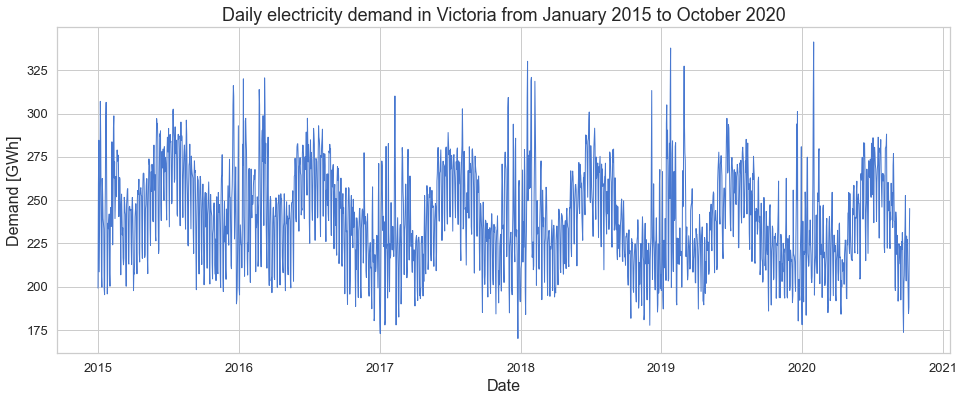

In [42]:
params = {'axes.labelsize': 16, 'axes.titlesize': 18, 'font.size': 15}
plt.rcParams.update(params)

fig, ax = plt.subplots(1, 1, figsize = (16, 6))
ax.tick_params(axis='both', which='major', labelsize=13)

df_demand['Demand'] = df_demand['Demand']/1000
df_demand.plot(x='Date', y='Demand', lw = 1, ax = ax)
df_demand['Demand'] = df_demand['Demand']*1000
ax.set_title("Daily electricity demand in Victoria from January 2015 to October 2020")
ax.set_ylabel("Demand [GWh]")
ax.get_legend().remove()
plt.savefig("demand.png", dpi=300)
None

There seem to be no strong global trend, but lots of seasonal variability. Nontheless, lets <b>plot logarithmic derivative.</b>

<AxesSubplot:xlabel='Date'>

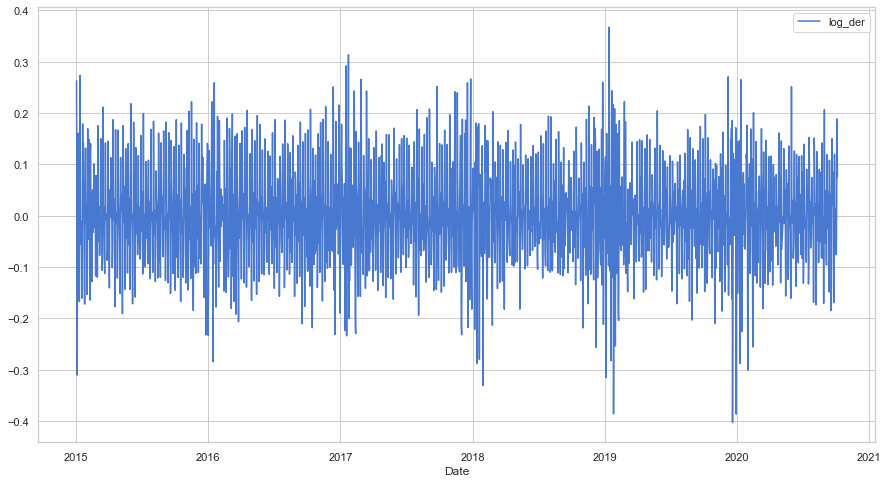

In [22]:
shift = 1
df_demand['log_der'] = np.log(df_demand['Demand']/df_demand['Demand'].shift(periods=shift))
df_demand[shift:].plot(x='Date', y='log_der', figsize=(15, 8))

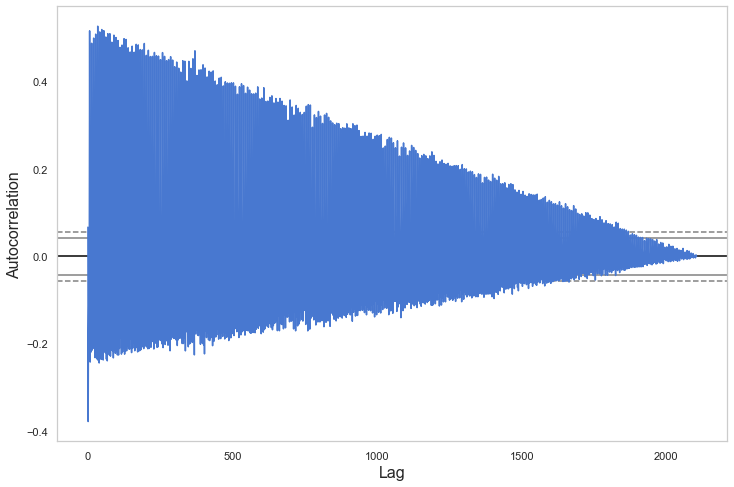

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

pd.plotting.autocorrelation_plot(df_demand[shift:]['log_der'], ax=ax)

plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

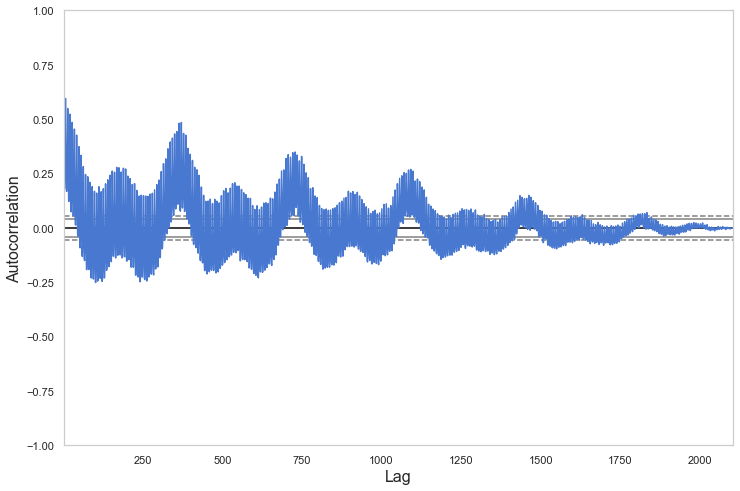

In [46]:
plt.figure(figsize=(12, 8))
pd.plotting.autocorrelation_plot(df_demand[shift:]['Demand'])

/home/alex/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 40000000.0)

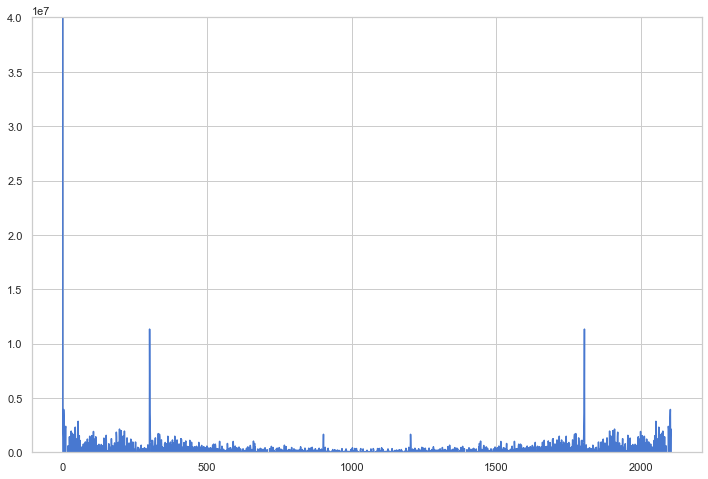

In [57]:
plt.figure(figsize=(12, 8))
ft = np.fft.fft(df_demand[shift:]['Demand'])
plt.plot(ft)
plt.ylim(0, 40000000)

Unprocessed demand has more structured autocorrelation function. Interestingly, this is reversed when granular 30 minutes data is used instead of daily aggregate.

<AxesSubplot:xlabel='Maximum Temperature (mod)'>

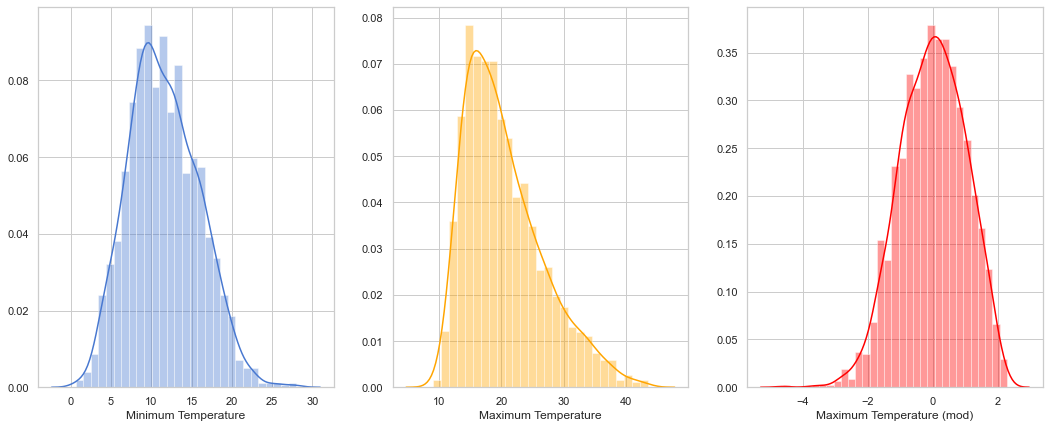

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

def shift_log(df, col_name):
    """
    Transform by shift so that min element = 1 and taking log
    """
    vals = df[col_name].values
    shift = np.min(vals)
    vals = np.log(vals - shift + 1)
    df[col_name + " (mod)"] = (vals - vals.mean())/vals.std()

shift_log(df_demand, 'Maximum Temperature')
    
sns.distplot(df_demand['Minimum Temperature'], ax=ax1)
sns.distplot(df_demand['Maximum Temperature'], color='orange', ax=ax2)
sns.distplot(df_demand['Maximum Temperature (mod)'], color='red', ax=ax3)

Meximum daily temperatures have a skewed distribution. However, some model better from a normalised data. Last plot on the right depicts normalised temperature. Below is a 2D histogram for minimum and maximum temperatures (normalised).

(0.6, 28.0, -4.603230698098529, 2.27166701098875)

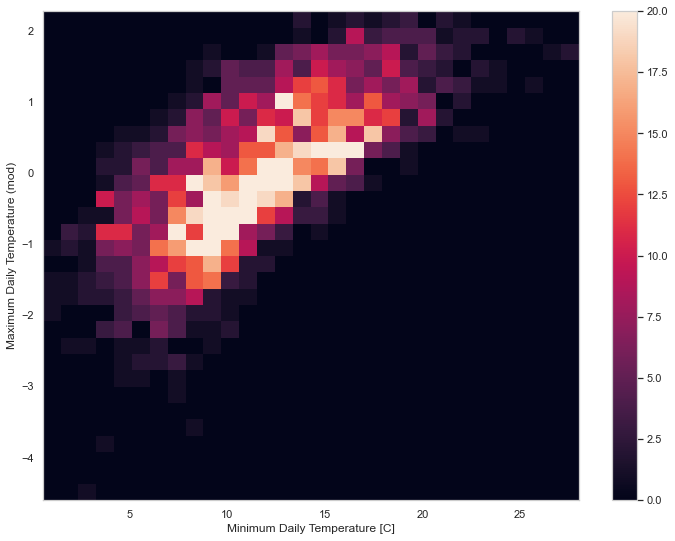

In [26]:
plt.figure(figsize = (12, 9))
plt.hist2d(df_demand['Minimum Temperature'], df_demand['Maximum Temperature (mod)'], bins=(30, 30), vmax=20)
plt.colorbar()
plt.xlabel('Minimum Daily Temperature [C]')
plt.ylabel('Maximum Daily Temperature (mod)')
ax = plt.gca()
ax.axis('tight')

Last, but far not the least, lets look at the frequency and a relative magnitude of demand at negative prices.

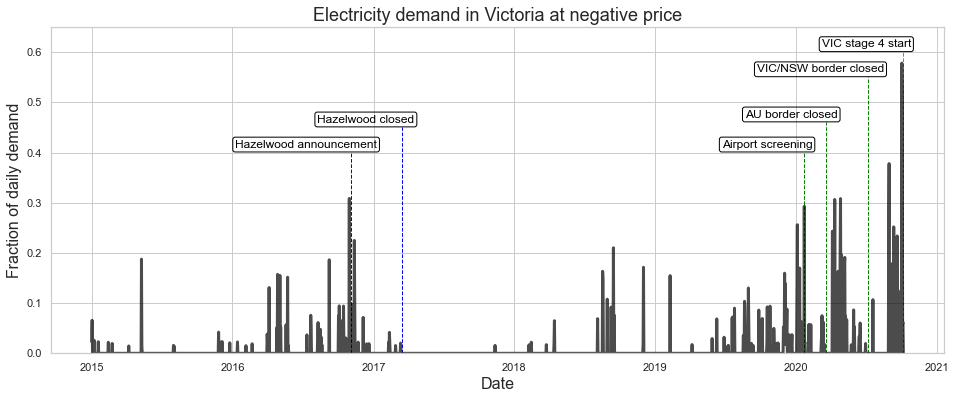

In [24]:
params = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'font.size': 12}
plt.rcParams.update(params)

plt.figure(figsize=(16, 6))
plt.plot(df_demand['Date'], df_demand['nDemand']/df_demand['Demand'], lw=3, color='black', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Fraction of daily demand')
plt.title("Electricity demand in Victoria at negative price")
plt.ylim([0, 0.65])

event = pd.to_datetime('03-11-2016', format='%d-%m-%Y')
plt.vlines(x = event, ymin=0, ymax=0.4, ls = '--', lw=1, color='blue')
label_event = pd.to_datetime('08-01-2016', format='%d-%m-%Y')
plt.text(label_event, 0.41, 'Hazelwood announcement', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))

event = pd.to_datetime('15-03-2017', format='%d-%m-%Y')
plt.vlines(x = event, ymin=0, ymax=0.45, ls = '--', lw=1, color='blue')
label_event = pd.to_datetime('08-08-2016', format='%d-%m-%Y')
plt.text(label_event, 0.46, 'Hazelwood closed', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))


event = pd.to_datetime('23-01-2020', format='%d-%m-%Y')
plt.vlines(x = event, ymin=0, ymax=0.4, ls = '--', lw=1, color='green')
label_event = pd.to_datetime('23-06-2019', format='%d-%m-%Y')
plt.text(label_event, 0.41, 'Airport screening', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))


event = pd.to_datetime('20-03-2020', format='%d-%m-%Y')
plt.vlines(x = event, ymin=0, ymax=0.46, ls = '--', lw=1, color='green')
label_event = pd.to_datetime('22-08-2019', format='%d-%m-%Y')
plt.text(label_event, 0.47, "AU border closed", color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))


event = pd.to_datetime('06-07-2020', format='%d-%m-%Y')
plt.vlines(x = event, ymin=0, ymax=0.55, ls = '--', lw=1, color='green')
label_event = pd.to_datetime('22-09-2019', format='%d-%m-%Y')
plt.text(label_event, 0.56, "VIC/NSW border closed", color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))


event = pd.to_datetime('05-10-2020', format='%d-%m-%Y')
plt.vlines(x = event, ymin=0, ymax=0.6, ls = '--', lw=1, color='green', alpha=0.7)
label_event = pd.to_datetime('08-03-2020', format='%d-%m-%Y')
plt.text(label_event, 0.61, 'VIC stage 4 start', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2'))

plt.savefig("neg_prices.png", dpi=300)